### Fracción de contactos nativos

Los contactos nativos determinan los mecanismos de plegamiento de proteínas en simulaciones atomísticas.

(𝑄(𝑋)=1 / |𝑆| * (∑(𝑖,𝑗)∈𝑆 (1 / (1 + exp[𝛽(𝑟𝑖𝑗(𝑋)−𝜆𝑟0𝑖𝑗]))


$X$ is a conformation,
$r_{ij}(X)$ is the distance between atoms $i$ and $j$ in conformation $X$,
$r^0_{ij}$ is the distance from heavy atom i to j in the native state conformation,
$S$ is the set of all pairs of heavy atoms $(i,j)$ belonging to residues $\theta_i$ and $\theta_j$ such that $|\theta_i - \theta_j| > 3$ and $r^0_{i,} < 4.5 \unicode{x212B}$,
$\beta=5 \unicode{x212B}^{-1}$,
$\lambda=1.8$ for all-atom simulations


In [1]:
import numpy as np
import mdtraj as md
from itertools import combinations

def best_hummer_q(traj, native):
    
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50 #1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45 # nanometers
    
    
    # Obtener los índices de todos los átomos pesados:
    
    heavy = native.topology.select_atom_indices('heavy')
    
    
    
    # Obtener los pares de átomos pesados que están más lejos de 3
    
    # - Residuos separados    
                                 
    heavy_pairs = np.array([(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])                        
                           
    
    # Calcular las distancias entre estos pares en el estado nativo:
        
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    
    
    
    # Obtener las parejas s.t. en las que la distancia es menor que NATIVE_CUTOFF:
    
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    
    print("Number of native contacts", len(native_contacts))
    
    
    
    # Calcular estas distancias para toda la trayectoria:
    
    r = md.compute_distances(traj, native_contacts)
    
    
    # Recomputar solo para el estado nativo
    
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    
    return q

In [2]:
# Extraer una proteína al azar del PDB 
# (La información de la celda unitaria es incorrecta)

traj = md.load_pdb('http://www.rcsb.org/pdb/files/2MI7.pdb')

# Utilizando el primer frame como la conformación 'nativa'

q = best_hummer_q(traj, traj[0])


Number of native contacts 526


/home/liliana/Myopt/Miniconda/miniconda3/envs/UIBCDF_lab/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


<function matplotlib.pyplot.show(*args, **kw)>

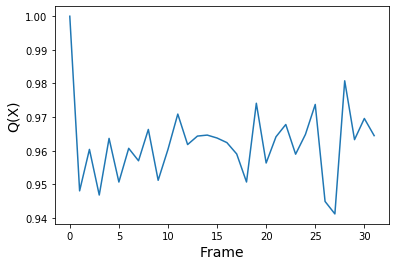

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(q)
plt.xlabel('Frame', fontsize = 14)
plt.ylabel('Q(X)', fontsize = 14)
plt.show